<div id="container" style="position:relative;">
<div style="float:left"><h1> Predicting NHL Goal Scoring - Feature Engineering </h1></div>
<br>
    <br>
    <br>

***BrainStation Data Science Capstone Project*** <br/>
***Author:***  &ensp;    **Taylor Gallivan** <br/>
***Date:*** &ensp; **Sep-Nov 2023** 

### Introduction

This notebook is for Feature Engineering of the cleaned data pulled from the NHL API.  

First feature engineering steps:
1. Recreate the shooting percentage feature - `shot_pct`
2. Divide all game statistic features by the number of games that a player played that season - this will make all of the statistics per game averages 
3. Binary encode `midseason_trades` so that all values are either 0 or 1
4. One-hot encode the following categorical columns:
    - `franchise`
    - `position_name`
5. Drop columns made redundant by one-hot encoding
6. Use ordinal encoding to give higher weighting to entries from the 'modern era', which is the era from the 2005-2006 season up until the most recent season, 2022-2023.  In total we will define three eras, applying the following weights:
    - Modern Era:  05-06 season to 22-23 season, weighting value of 3
    - Pre-Modern Era:  97-98 season to 03-04 season, weighting value of 2
    - Pre-TOI Era:  79-80 season to 96-97 season, weight value of 1 (prior to the 97-98 season, time on ice statistics were not tracked by the league - our values for these stastics are averages) 

In [137]:
# import libraries
import pandas as pd
pd.set_option('display.max_columns', None)
from datetime import datetime
import numpy as np
import matplotlib.pyplot as plt

In [138]:
# Load the data back in
df = pd.read_csv('NHL_data_condensed_5.csv')

# sort values, to be sure
df = df.sort_values(by=['player_id', 'season_start_yr'])

# reset index, to be sure
df.reset_index(drop=True, inplace=True)

# check the shape...for sanity
df.shape

(24503, 29)

In [139]:
df.head()

,player_id,name,height,weight,position_name,position_type,season_start_yr,player_age,franchise,goals,game_winning_goals,power_play_goals,short_handed_goals,shots,games_played,shifts,assists,points,power_play_points,short_handed_points,plus_minus,penalty_minutes,hits,blocked,total_toi,even_strength_toi,power_play_toi,short_handed_toi,midseason_trades
0,8444894,Greg Adams,76,196,Left Wing,Forward,1984,21,NJD,12.0,0.0,5.0,0.0,65.0,36,688.693839,9.0,21.0,6.0,0.0,-14.0,9,43.351520,10.212643,524.456686,431.340444,61.218289,31.898058,0
1,8444894,Greg Adams,76,196,Left Wing,Forward,1985,22,NJD,35.0,2.0,10.0,0.0,202.0,78,1492.169986,42.0,77.0,21.0,0.0,-7.0,30,93.928293,22.127393,1136.322819,934.570962,132.639625,69.112458,0
2,8444894,Greg Adams,76,196,Left Wing,Forward,1986,23,NJD,20.0,1.0,6.0,0.0,140.0,72,1377.387679,27.0,47.0,16.0,0.0,-16.0,19,86.703040,20.425286,1048.913372,862.680888,122.436577,63.796115,0
3,8444894,Greg Adams,76,196,Left Wing,Forward,1987,24,VAN,36.0,3.0,12.0,0.0,227.0,80,1530.430754,40.0,76.0,28.0,0.0,-24.0,30,96.336711,22.694762,1165.459302,958.534320,136.040641,70.884572,0
4,8444894,Greg Adams,76,196,Left Wing,Forward,1988,25,VAN,19.0,2.0,9.0,0.0,144.0,61,1166.953450,14.0,33.0,14.0,0.0,-21.0,24,73.456742,17.304756,888.662718,730.882419,103.730989,54.049486,0


In [140]:
# review full column list and datatypes
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 24503 entries, 0 to 24502
Data columns (total 29 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   player_id            24503 non-null  int64  
 1   name                 24503 non-null  object 
 2   height               24503 non-null  int64  
 3   weight               24503 non-null  int64  
 4   position_name        24503 non-null  object 
 5   position_type        24503 non-null  object 
 6   season_start_yr      24503 non-null  int64  
 7   player_age           24503 non-null  int64  
 8   franchise            24503 non-null  object 
 9   goals                24503 non-null  float64
 10  game_winning_goals   24503 non-null  float64
 11  power_play_goals     24503 non-null  float64
 12  short_handed_goals   24503 non-null  float64
 13  shots                24503 non-null  float64
 14  games_played         24503 non-null  int64  
 15  shifts               24503 non-null 

#### Step 1 - Recreate Shooting Percentage Feature

***I am holding off on this step for the time being because, for this initial round of modelling, it is expected to be collinear with `shots`; therefore, we cannot have both of these features present in the features matrix.***

The stat `shot_pct` was dropped from the original dataset because, as a percentage, it would not have responded well to some of the preprocessing steps that involved groupby aggregations - for instance, the step where rows were aggreagted to flatten the `sequence_number` feature.

Now, that we have per season totals for all statistical categories, we can recalculate it but dividing number of goals scored in a season, by number of shots taken each season, for each player/entry in the DataFrame.  

In [141]:
#df['shot_pct'] = df['goals'] / df['shots']

In [142]:
# # Check the distribution
# plt.figure()
# plt.hist(df['shot_pct'], bins=50)

# # Set the titles and labels
# plt.title('Distribution of Shooting Percentage')
# plt.xlabel('Shooting Percentage')
# plt.ylabel('Frequency')
# plt.yscale('log')

# plt.show()

Check the first and last few entries in the DataFrame to make sure `shot_pct` was correctly implemented.

In [143]:
# df

Looks good!  Next step...

#### Step 2 - Get Per Game Averages
Dividing each gameplay statistic by the number of games that that player played that season will allow entries to be compared.  It will be easier to process this if all the statistical features relating to gameplay are in sequential order at the end of the DataFrame. The exception here is the shooting percentage feature that was just created - this is already an average, but based on shots taken rather than games played.  
Re-order the DataFrame based on the above premise:

In [144]:
# these columns to front of DataFrame
player_stats = df.loc[:, ['player_id', 'name', 'height', 'weight', 'position_name', 'position_type', 'season_start_yr', 'player_age', \
                         'franchise', 'midseason_trades', 'games_played']]  # , 'shot_pct']]
# sanity check
print(player_stats.shape)

# these columns to end of DataFrame
gameplay_stats = df.loc[:, ['goals', 'game_winning_goals', 'power_play_goals', 'short_handed_goals', 'shots', 'assists', 'points', \
                            'power_play_points', 'short_handed_points', 'plus_minus', 'penalty_minutes', 'hits', 'blocked', 'shifts',
                           'total_toi', 'even_strength_toi', 'power_play_toi', 'short_handed_toi']]
# sanity check
print(gameplay_stats.shape)

(24503, 11)
(24503, 18)


In [145]:
df = player_stats.join(gameplay_stats)
df

,player_id,name,height,weight,position_name,position_type,season_start_yr,player_age,franchise,midseason_trades,games_played,goals,game_winning_goals,power_play_goals,short_handed_goals,shots,assists,points,power_play_points,short_handed_points,plus_minus,penalty_minutes,hits,blocked,shifts,total_toi,even_strength_toi,power_play_toi,short_handed_toi
0,8444894,Greg Adams,76,196,Left Wing,Forward,1984,21,NJD,0,36,12.0,0.0,5.0,0.0,65.0,9.0,21.0,6.0,0.0,-14.0,9,43.351520,10.212643,688.693839,524.456686,431.340444,61.218289,31.898058
1,8444894,Greg Adams,76,196,Left Wing,Forward,1985,22,NJD,0,78,35.0,2.0,10.0,0.0,202.0,42.0,77.0,21.0,0.0,-7.0,30,93.928293,22.127393,1492.169986,1136.322819,934.570962,132.639625,69.112458
2,8444894,Greg Adams,76,196,Left Wing,Forward,1986,23,NJD,0,72,20.0,1.0,6.0,0.0,140.0,27.0,47.0,16.0,0.0,-16.0,19,86.703040,20.425286,1377.387679,1048.913372,862.680888,122.436577,63.796115
3,8444894,Greg Adams,76,196,Left Wing,Forward,1987,24,VAN,0,80,36.0,3.0,12.0,0.0,227.0,40.0,76.0,28.0,0.0,-24.0,30,96.336711,22.694762,1530.430754,1165.459302,958.534320,136.040641,70.884572
4,8444894,Greg Adams,76,196,Left Wing,Forward,1988,25,VAN,0,61,19.0,2.0,9.0,0.0,144.0,14.0,33.0,14.0,0.0,-21.0,24,73.456742,17.304756,1166.953450,888.662718,730.882419,103.730989,54.049486
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
24498,8482116,Tim Stützle,72,197,Center,Forward,2021,19,OTT,0,79,22.0,4.0,7.0,1.0,176.0,36.0,58.0,26.0,1.0,-27.0,37,125.000000,52.000000,1678.000000,1454.500000,1188.050000,256.050000,10.400000
24499,8482116,Tim Stützle,72,197,Center,Forward,2022,20,OTT,0,78,39.0,3.0,10.0,3.0,228.0,51.0,90.0,28.0,3.0,-3.0,54,114.000000,49.000000,2021.000000,1658.670000,1247.430000,312.830000,98.400000
24500,8482245,Artem Zub,75,204,Defenseman,Defenseman,2020,25,OTT,0,47,3.0,1.0,0.0,0.0,39.0,11.0,14.0,0.0,0.0,4.0,26,89.000000,70.000000,1112.000000,863.970000,759.800000,3.200000,100.970000
24501,8482245,Artem Zub,75,204,Defenseman,Defenseman,2021,26,OTT,0,81,6.0,0.0,0.0,0.0,92.0,16.0,22.0,0.0,0.0,1.0,60,155.000000,124.000000,2042.000000,1704.230000,1531.970000,21.500000,150.770000


Columns in correct order, indexes unchanged. 

In [146]:
# select the gameplay stats columns
game_stats = df.iloc[:, -18:]

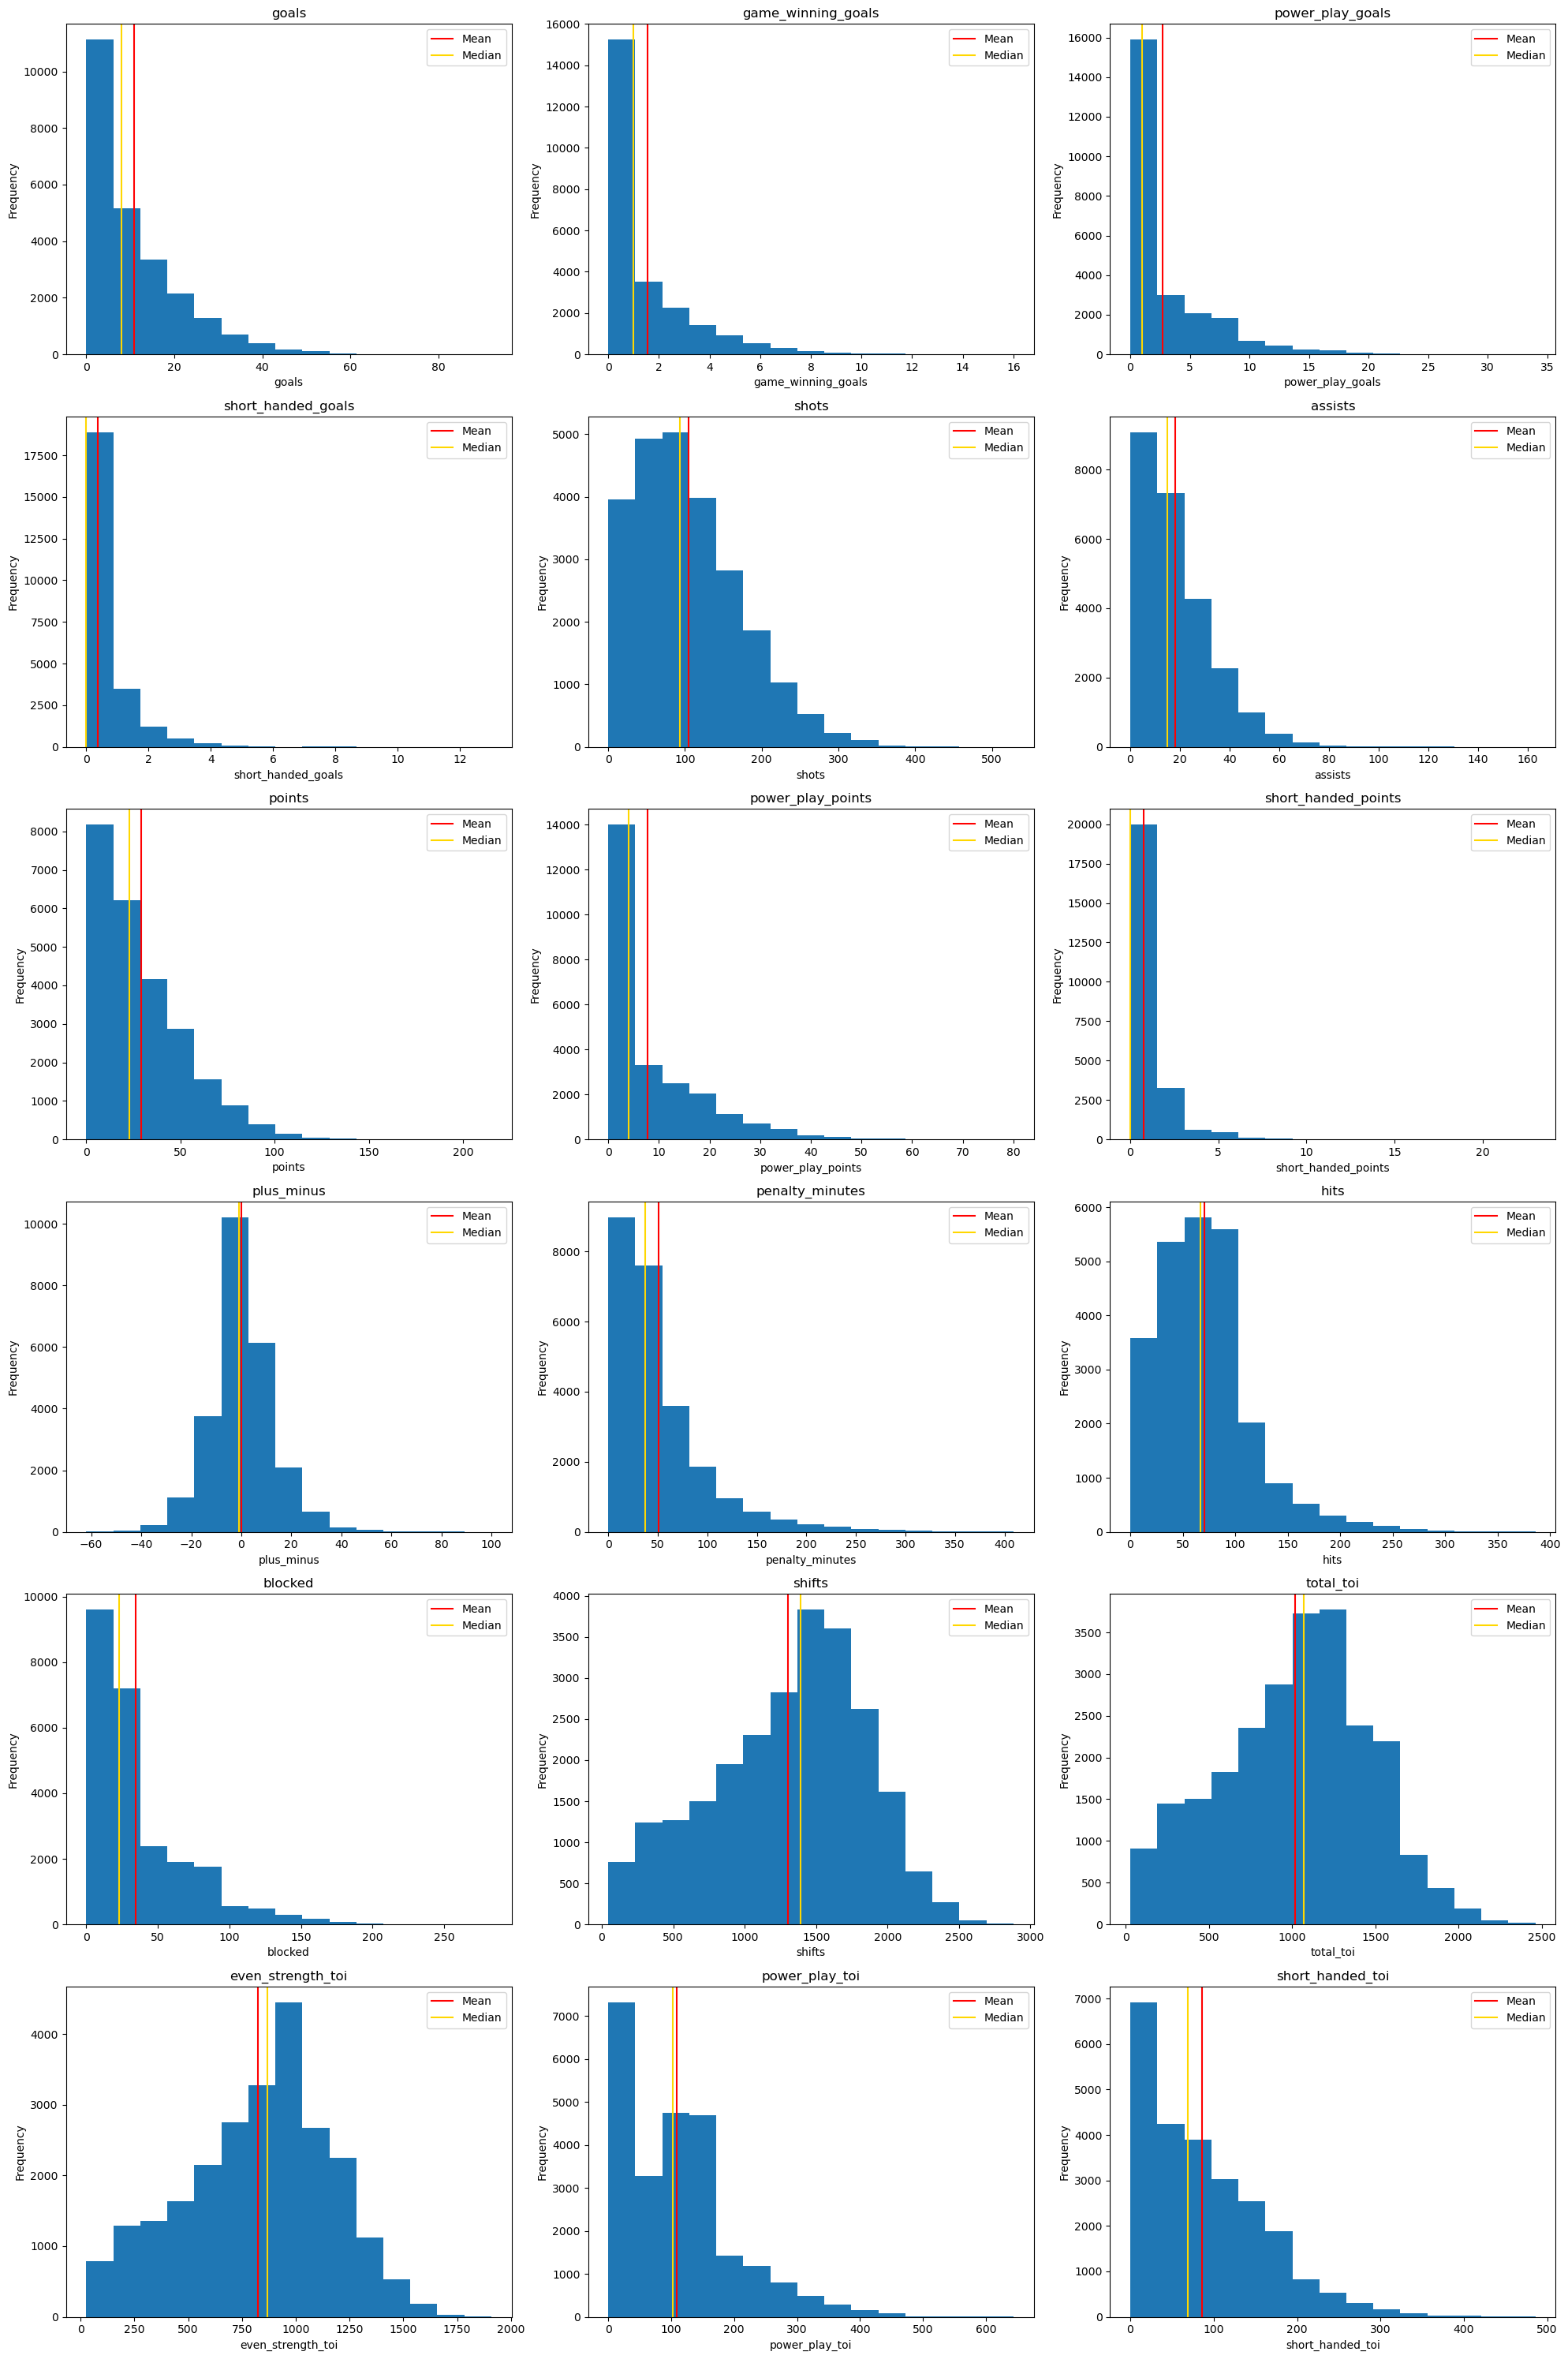

In [147]:
# plot distributions for comparison after computation

# plot will have 6 rows, 3 subplots per row
plt.subplots(6, 3, figsize=(20,30))

# Creating the for loop
for slot_num, each_column in enumerate(game_stats.columns, start=1):
    
    # Creating a hist for every iteration
    plt.subplot(6,3,slot_num)
    plt.hist(game_stats[each_column], bins=15)
    
    # Set the titles and labels
    plt.title(each_column)
    plt.xlabel(each_column)
    plt.ylabel('Frequency')
    
    # Adding median and mean lines
    plt.axvline(game_stats[each_column].mean(), c='red', label='Mean')
    plt.axvline(game_stats[each_column].median(), c='gold', label='Median')
    plt.legend()
    
plt.tight_layout()

plt.show()

In [148]:
# divide each gameplay stat by number of games_played
# axis=0 specifies to divide along the rows
df.iloc[:, -18:] = game_stats.div(df['games_played'], axis=0)

In [149]:
# reselect the gameplay stats columns
game_stats = df.iloc[:, -18:]

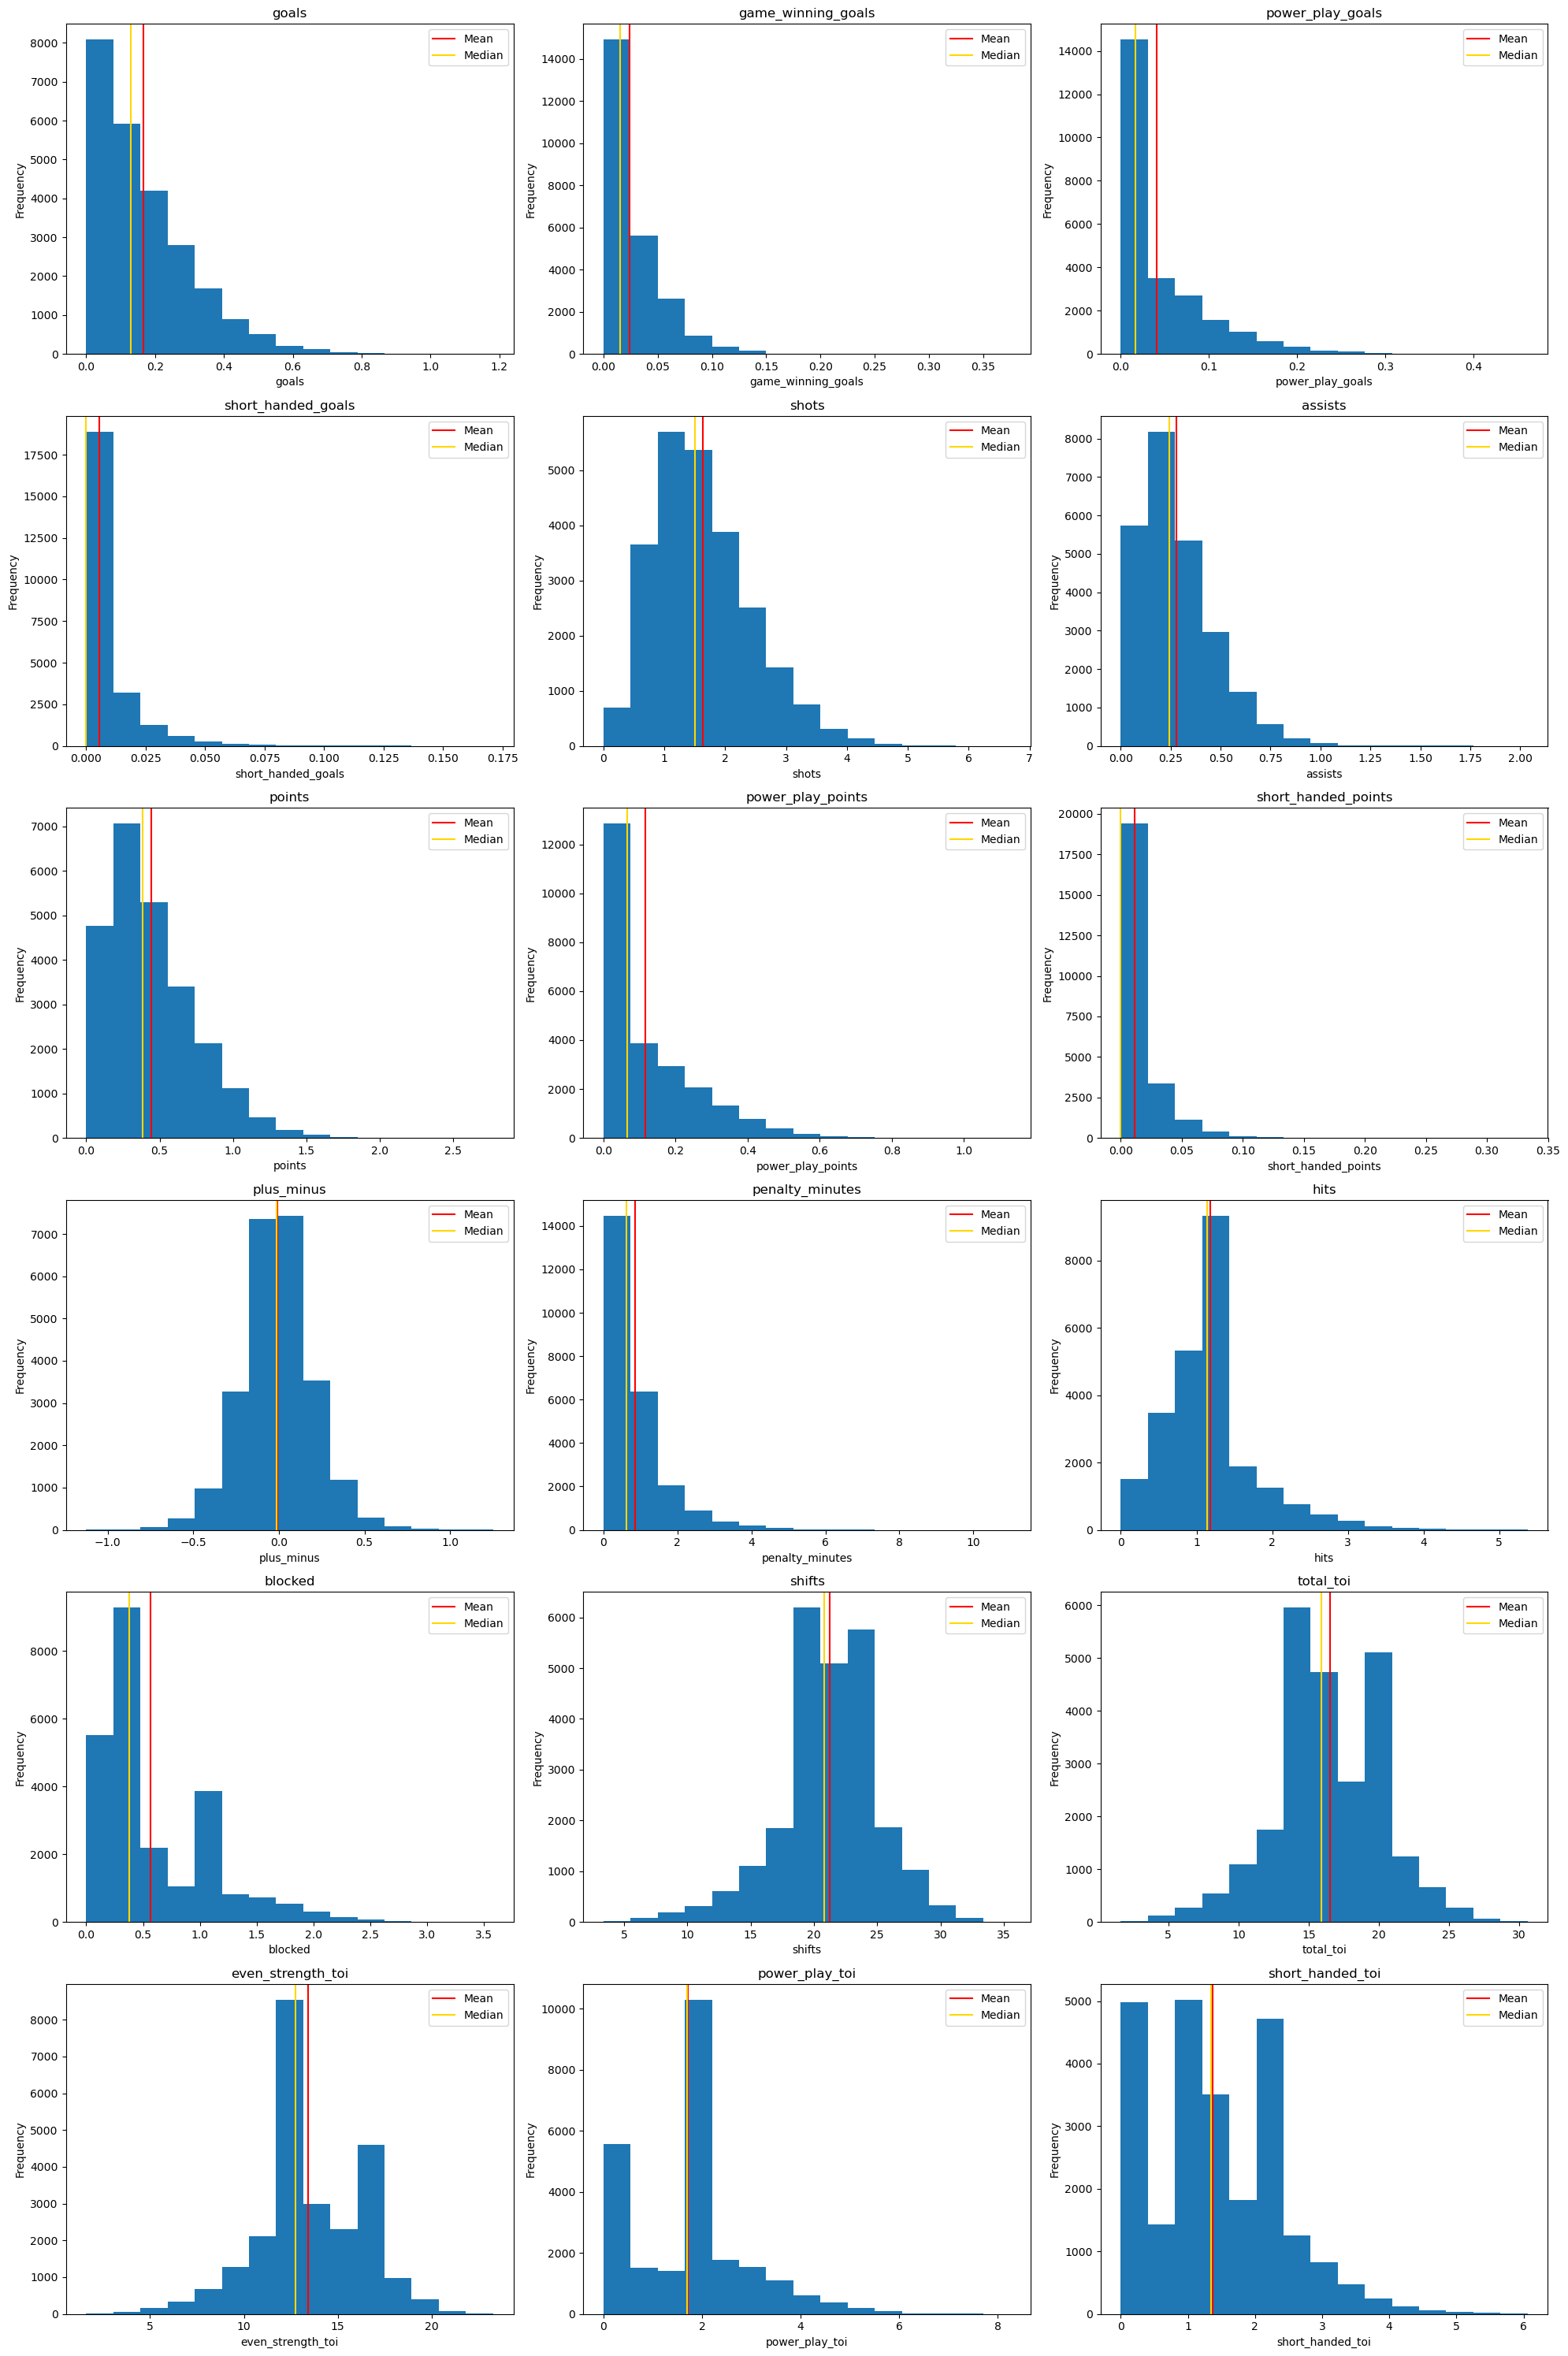

In [150]:
# replot distributions after computation

# plot will have 6 rows, 3 subplots per row
plt.subplots(6, 3, figsize=(20,30))

# Creating the for loop
for slot_num, each_column in enumerate(game_stats.columns, start=1):
    
    # Creating a hist for every iteration
    plt.subplot(6,3,slot_num)
    plt.hist(game_stats[each_column], bins=15)
    
    # Set the titles and labels
    plt.title(each_column)
    plt.xlabel(each_column)
    plt.ylabel('Frequency')
    
    # Adding median and mean lines
    plt.axvline(game_stats[each_column].mean(), c='red', label='Mean')
    plt.axvline(game_stats[each_column].median(), c='gold', label='Median')
    plt.legend()

plt.tight_layout()

plt.show()

Check the first few and last few entries to validate the computation accuracy

In [151]:
df

,player_id,name,height,weight,position_name,position_type,season_start_yr,player_age,franchise,midseason_trades,games_played,goals,game_winning_goals,power_play_goals,short_handed_goals,shots,assists,points,power_play_points,short_handed_points,plus_minus,penalty_minutes,hits,blocked,shifts,total_toi,even_strength_toi,power_play_toi,short_handed_toi
0,8444894,Greg Adams,76,196,Left Wing,Forward,1984,21,NJD,0,36,0.333333,0.000000,0.138889,0.000000,1.805556,0.250000,0.583333,0.166667,0.000000,-0.388889,0.250000,1.204209,0.283685,19.130384,14.568241,11.981679,1.700508,0.886057
1,8444894,Greg Adams,76,196,Left Wing,Forward,1985,22,NJD,0,78,0.448718,0.025641,0.128205,0.000000,2.589744,0.538462,0.987179,0.269231,0.000000,-0.089744,0.384615,1.204209,0.283685,19.130384,14.568241,11.981679,1.700508,0.886057
2,8444894,Greg Adams,76,196,Left Wing,Forward,1986,23,NJD,0,72,0.277778,0.013889,0.083333,0.000000,1.944444,0.375000,0.652778,0.222222,0.000000,-0.222222,0.263889,1.204209,0.283685,19.130384,14.568241,11.981679,1.700508,0.886057
3,8444894,Greg Adams,76,196,Left Wing,Forward,1987,24,VAN,0,80,0.450000,0.037500,0.150000,0.000000,2.837500,0.500000,0.950000,0.350000,0.000000,-0.300000,0.375000,1.204209,0.283685,19.130384,14.568241,11.981679,1.700508,0.886057
4,8444894,Greg Adams,76,196,Left Wing,Forward,1988,25,VAN,0,61,0.311475,0.032787,0.147541,0.000000,2.360656,0.229508,0.540984,0.229508,0.000000,-0.344262,0.393443,1.204209,0.283685,19.130384,14.568241,11.981679,1.700508,0.886057
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
24498,8482116,Tim Stützle,72,197,Center,Forward,2021,19,OTT,0,79,0.278481,0.050633,0.088608,0.012658,2.227848,0.455696,0.734177,0.329114,0.012658,-0.341772,0.468354,1.582278,0.658228,21.240506,18.411392,15.038608,3.241139,0.131646
24499,8482116,Tim Stützle,72,197,Center,Forward,2022,20,OTT,0,78,0.500000,0.038462,0.128205,0.038462,2.923077,0.653846,1.153846,0.358974,0.038462,-0.038462,0.692308,1.461538,0.628205,25.910256,21.265000,15.992692,4.010641,1.261538
24500,8482245,Artem Zub,75,204,Defenseman,Defenseman,2020,25,OTT,0,47,0.063830,0.021277,0.000000,0.000000,0.829787,0.234043,0.297872,0.000000,0.000000,0.085106,0.553191,1.893617,1.489362,23.659574,18.382340,16.165957,0.068085,2.148298
24501,8482245,Artem Zub,75,204,Defenseman,Defenseman,2021,26,OTT,0,81,0.074074,0.000000,0.000000,0.000000,1.135802,0.197531,0.271605,0.000000,0.000000,0.012346,0.740741,1.913580,1.530864,25.209877,21.039877,18.913210,0.265432,1.861358


#### Step 3 - Binary Encoding
Use a map to binary encode the values of `mideason_trades`:  values of 0 will remain 0, anything above 0 assigned a value of 1.

In [152]:
df['midseason_trades'].value_counts()

midseason_trades
0    21855
1     2526
2      120
3        2
Name: count, dtype: int64

In [153]:
df['midseason_trades'] = df['midseason_trades'].map({0: 0, 1: 1, 2: 1, 3: 1})

In [154]:
# sanity check
df['midseason_trades'].value_counts()

midseason_trades
0    21855
1     2648
Name: count, dtype: int64

#### Step 4 - One-Hot Encoding
Use OneHotEncoder from sklearn to convert the categorical features `franchise` and `position_name` to numerical features.

In [155]:
# import necessary library
from sklearn.preprocessing import OneHotEncoder

In [156]:
# Instantiate the OneHotEncoder
ohe = OneHotEncoder()

# Fit the OneHotEncoder to 'franchise' column
# It expects a 2D array, so we first convert the column into a DataFrame
franchise = pd.DataFrame(df['franchise'])
encoded = ohe.fit_transform(franchise)
encoded

<24503x32 sparse matrix of type '<class 'numpy.float64'>'
	with 24503 stored elements in Compressed Sparse Row format>

In [157]:
# Convert from sparse matrix to dense
dense_array = encoded.toarray()
dense_array

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

In [158]:
# check list of franchises
ohe.categories_

[array(['ANA', 'ARI', 'BOS', 'BUF', 'CAR', 'CBJ', 'CGY', 'CHI', 'COL',
        'DAL', 'DET', 'EDM', 'FLA', 'LAK', 'MIN', 'MTL', 'NJD', 'NSH',
        'NYI', 'NYR', 'OTT', 'PHI', 'PIT', 'SEA', 'SJS', 'STL', 'TBL',
        'TOR', 'VAN', 'VGK', 'WIN', 'WSH'], dtype=object)]

In [159]:
# Put into a dataframe to get column names
franchise_encoded = pd.DataFrame(dense_array, columns=ohe.categories_, dtype=int)
franchise_encoded

,ANA,ARI,BOS,BUF,CAR,CBJ,CGY,CHI,COL,DAL,DET,EDM,FLA,LAK,MIN,MTL,NJD,NSH,NYI,NYR,OTT,PHI,PIT,SEA,SJS,STL,TBL,TOR,VAN,VGK,WIN,WSH
0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0
4,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
24498,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0
24499,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0
24500,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0
24501,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0


Repeat the process for `position_name`

In [160]:
# reinstantiate the OneHotEncoder
ohe = OneHotEncoder()

# Fit the OneHotEncoder to 'position_name' column
# It expects a 2D array, so we first convert the column into a DataFrame
position = pd.DataFrame(df['position_name'])
encoded = ohe.fit_transform(position)
encoded

<24503x4 sparse matrix of type '<class 'numpy.float64'>'
	with 24503 stored elements in Compressed Sparse Row format>

In [161]:
# Convert from sparse matrix to dense
dense_array = encoded.toarray()
dense_array

array([[0., 0., 1., 0.],
       [0., 0., 1., 0.],
       [0., 0., 1., 0.],
       ...,
       [0., 1., 0., 0.],
       [0., 1., 0., 0.],
       [0., 1., 0., 0.]])

In [162]:
# check list of franchises
ohe.categories_

[array(['Center', 'Defenseman', 'Left Wing', 'Right Wing'], dtype=object)]

In [163]:
# Put into a dataframe to get column names
position_encoded = pd.DataFrame(dense_array, columns=ohe.categories_, dtype=int)
position_encoded

,Center,Defenseman,Left Wing,Right Wing
0,0,0,1,0
1,0,0,1,0
2,0,0,1,0
3,0,0,1,0
4,0,0,1,0
...,...,...,...,...
24498,1,0,0,0
24499,1,0,0,0
24500,0,1,0,0
24501,0,1,0,0


Merge the DataFrames of encoded categorical values back into the original DataFrame.

In [164]:
# join DataFrames
df = df.join(franchise_encoded.join(position_encoded))
df

,player_id,name,height,weight,position_name,position_type,season_start_yr,player_age,franchise,midseason_trades,games_played,goals,game_winning_goals,power_play_goals,short_handed_goals,shots,assists,points,power_play_points,short_handed_points,plus_minus,penalty_minutes,hits,blocked,shifts,total_toi,even_strength_toi,power_play_toi,short_handed_toi,"(ANA,)","(ARI,)","(BOS,)","(BUF,)","(CAR,)","(CBJ,)","(CGY,)","(CHI,)","(COL,)","(DAL,)","(DET,)","(EDM,)","(FLA,)","(LAK,)","(MIN,)","(MTL,)","(NJD,)","(NSH,)","(NYI,)","(NYR,)","(OTT,)","(PHI,)","(PIT,)","(SEA,)","(SJS,)","(STL,)","(TBL,)","(TOR,)","(VAN,)","(VGK,)","(WIN,)","(WSH,)","(Center,)","(Defenseman,)","(Left Wing,)","(Right Wing,)"
0,8444894,Greg Adams,76,196,Left Wing,Forward,1984,21,NJD,0,36,0.333333,0.000000,0.138889,0.000000,1.805556,0.250000,0.583333,0.166667,0.000000,-0.388889,0.250000,1.204209,0.283685,19.130384,14.568241,11.981679,1.700508,0.886057,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0
1,8444894,Greg Adams,76,196,Left Wing,Forward,1985,22,NJD,0,78,0.448718,0.025641,0.128205,0.000000,2.589744,0.538462,0.987179,0.269231,0.000000,-0.089744,0.384615,1.204209,0.283685,19.130384,14.568241,11.981679,1.700508,0.886057,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0
2,8444894,Greg Adams,76,196,Left Wing,Forward,1986,23,NJD,0,72,0.277778,0.013889,0.083333,0.000000,1.944444,0.375000,0.652778,0.222222,0.000000,-0.222222,0.263889,1.204209,0.283685,19.130384,14.568241,11.981679,1.700508,0.886057,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0
3,8444894,Greg Adams,76,196,Left Wing,Forward,1987,24,VAN,0,80,0.450000,0.037500,0.150000,0.000000,2.837500,0.500000,0.950000,0.350000,0.000000,-0.300000,0.375000,1.204209,0.283685,19.130384,14.568241,11.981679,1.700508,0.886057,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0
4,8444894,Greg Adams,76,196,Left Wing,Forward,1988,25,VAN,0,61,0.311475,0.032787,0.147541,0.000000,2.360656,0.229508,0.540984,0.229508,0.000000,-0.344262,0.393443,1.204209,0.283685,19.130384,14.568241,11.981679,1.700508,0.886057,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
24498,8482116,Tim Stützle,72,197,Center,Forward,2021,19,OTT,0,79,0.278481,0.050633,0.088608,0.012658,2.227848,0.455696,0.734177,0.329114,0.012658,-0.341772,0.468354,1.582278,0.658228,21.240506,18.411392,15.038608,3.241139,0.131646,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0
24499,8482116,Tim Stützle,72,197,Center,Forward,2022,20,OTT,0,78,0.500000,0.038462,0.128205,0.038462,2.923077,0.653846,1.153846,0.358974,0.038462,-0.038462,0.692308,1.461538,0.628205,25.910256,21.265000,15.992692,4.010641,1.261538,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0
24500,8482245,Artem Zub,75,204,Defenseman,Defenseman,2020,25,OTT,0,47,0.063830,0.021277,0.000000,0.000000,0.829787,0.234043,0.297872,0.000000,0.000000,0.085106,0.553191,1.893617,1.489362,23.659574,18.382340,16.165957,0.068085,2.148298,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0
24501,8482245,Artem Zub,75,204,Defenseman,Defenseman,2021,26,OTT,0,81,0.074074,0.000000,0.000000,0.000000,1.135802,0.197531,0.271605,0.000000,0.000000,0.012346,0.740741,1.913580,1.530864,25.209877,21.039877,18.913210,0.265432,1.861358,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0


In [165]:
new_columns = df.columns

In [166]:
# You want to strip spaces and parentheses from each column name in the Index
new_columns = [col.strip(",\)\(\'").lower() for col in new_columns.astype(str)]

# To assign these cleaned names back to the DataFrame's columns
df.columns = new_columns
df.columns = [col.replace(" ", "_") for col in df.columns]
df.columns

Index(['player_id', 'name', 'height', 'weight', 'position_name',
       'position_type', 'season_start_yr', 'player_age', 'franchise',
       'midseason_trades', 'games_played', 'goals', 'game_winning_goals',
       'power_play_goals', 'short_handed_goals', 'shots', 'assists', 'points',
       'power_play_points', 'short_handed_points', 'plus_minus',
       'penalty_minutes', 'hits', 'blocked', 'shifts', 'total_toi',
       'even_strength_toi', 'power_play_toi', 'short_handed_toi', 'ana', 'ari',
       'bos', 'buf', 'car', 'cbj', 'cgy', 'chi', 'col', 'dal', 'det', 'edm',
       'fla', 'lak', 'min', 'mtl', 'njd', 'nsh', 'nyi', 'nyr', 'ott', 'phi',
       'pit', 'sea', 'sjs', 'stl', 'tbl', 'tor', 'van', 'vgk', 'win', 'wsh',
       'center', 'defenseman', 'left_wing', 'right_wing'],
      dtype='object')

In [167]:
df.head()

,player_id,name,height,weight,position_name,position_type,season_start_yr,player_age,franchise,midseason_trades,games_played,goals,game_winning_goals,power_play_goals,short_handed_goals,shots,assists,points,power_play_points,short_handed_points,plus_minus,penalty_minutes,hits,blocked,shifts,total_toi,even_strength_toi,power_play_toi,short_handed_toi,ana,ari,bos,buf,car,cbj,cgy,chi,col,dal,det,edm,fla,lak,min,mtl,njd,nsh,nyi,nyr,ott,phi,pit,sea,sjs,stl,tbl,tor,van,vgk,win,wsh,center,defenseman,left_wing,right_wing
0,8444894,Greg Adams,76,196,Left Wing,Forward,1984,21,NJD,0,36,0.333333,0.000000,0.138889,0.0,1.805556,0.250000,0.583333,0.166667,0.0,-0.388889,0.250000,1.204209,0.283685,19.130384,14.568241,11.981679,1.700508,0.886057,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0
1,8444894,Greg Adams,76,196,Left Wing,Forward,1985,22,NJD,0,78,0.448718,0.025641,0.128205,0.0,2.589744,0.538462,0.987179,0.269231,0.0,-0.089744,0.384615,1.204209,0.283685,19.130384,14.568241,11.981679,1.700508,0.886057,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0
2,8444894,Greg Adams,76,196,Left Wing,Forward,1986,23,NJD,0,72,0.277778,0.013889,0.083333,0.0,1.944444,0.375000,0.652778,0.222222,0.0,-0.222222,0.263889,1.204209,0.283685,19.130384,14.568241,11.981679,1.700508,0.886057,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0
3,8444894,Greg Adams,76,196,Left Wing,Forward,1987,24,VAN,0,80,0.450000,0.037500,0.150000,0.0,2.837500,0.500000,0.950000,0.350000,0.0,-0.300000,0.375000,1.204209,0.283685,19.130384,14.568241,11.981679,1.700508,0.886057,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0
4,8444894,Greg Adams,76,196,Left Wing,Forward,1988,25,VAN,0,61,0.311475,0.032787,0.147541,0.0,2.360656,0.229508,0.540984,0.229508,0.0,-0.344262,0.393443,1.204209,0.283685,19.130384,14.568241,11.981679,1.700508,0.886057,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0


#### Step 5 - Drop Redundant Columns
The categorical columns `franchise` and `position_name` can now be dropped, as they are redundant.  `position_type` can also be dropped - it was not included in the one-hot encoding because it is simply a less granular version of `position_name`

In [168]:
# execute column drop
df = df.drop(columns=['franchise', 'position_name', 'position_type'])
df.columns

Index(['player_id', 'name', 'height', 'weight', 'season_start_yr',
       'player_age', 'midseason_trades', 'games_played', 'goals',
       'game_winning_goals', 'power_play_goals', 'short_handed_goals', 'shots',
       'assists', 'points', 'power_play_points', 'short_handed_points',
       'plus_minus', 'penalty_minutes', 'hits', 'blocked', 'shifts',
       'total_toi', 'even_strength_toi', 'power_play_toi', 'short_handed_toi',
       'ana', 'ari', 'bos', 'buf', 'car', 'cbj', 'cgy', 'chi', 'col', 'dal',
       'det', 'edm', 'fla', 'lak', 'min', 'mtl', 'njd', 'nsh', 'nyi', 'nyr',
       'ott', 'phi', 'pit', 'sea', 'sjs', 'stl', 'tbl', 'tor', 'van', 'vgk',
       'win', 'wsh', 'center', 'defenseman', 'left_wing', 'right_wing'],
      dtype='object')

#### Step 6 - Ordinal Encoding 

***I am holding off on this step for the time being, until I get a working base model running. Using ordinal encoding here may assign too much value to the recent data - better to see what the baseline looks like first.*** 

Create a new feature called `era` and apply ordinal encoding based on the following criteria:

| starting year | ending year | era value |
| :-----: | :-----: | :-----: |
| 1979 | 1996 |  1  |
| 1997 | 2003 |  2  |
| 2005 | 2022 |  3  |


## *Checkpoint*
**Save:**

In [169]:
# Save progress
#df.to_csv('NHL_data_clean_1.csv', index=False)

### Advanced Feature Engineering

Some ideas for advanced feature engineering:
- Era adjusted scoring
- Try ordinal encoding for shifts/game
- Try using one-hot encoding on `position_type`, instead of `position_name`

Also:
- Re-do the TOI fix with the spreadsheet found online